# Advanced Lane Lines

## Camera Calibration

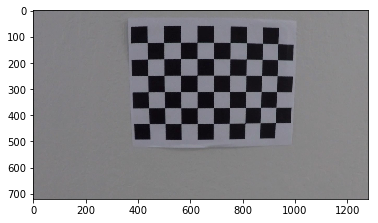

In [1]:
import numpy as np
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
%matplotlib inline

# Read in a calibration image
img = mpimg.imread('camera_cal/calibration18.jpg')
plt.imshow(img)

In [2]:
import glob

# Read in and make a list of calibration images
images = glob.glob('camera_cal/calibration*.jpg')

In [3]:
# Arrays to store object points and image points from all the images
objpoints = [] # 3D points in real world space
imgpoints = [] # 2D points in image plane
img_size = (0, 0)

# Prepare object points, like (0,0,0), (1,0,0), (2,0,0) ...., (8,5,0)
objp = np.zeros((6*9,3), np.float32)
objp[:,:2] = np.mgrid[0:9,0:6].T.reshape(-1,2) # x, y coordinates

# For every image
for filename in images:
    # Read in calibration image
    img = mpimg.imread(filename)
    
    # Convert image to grayscale
    gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
    
    img_size = gray.shape[::-1]
    
    # Find the chessboard corners
    ret, corners = cv2.findChessboardCorners(gray, (9,6), None)
    
    # If corners are found, add object points, image points
    if ret == True:
        imgpoints.append(corners)
        objpoints.append(objp)
        
        # Draw and display the corners
        #img = cv2.drawChessboardCorners(img, (9,6), corners, ret)
        #plt.imshow(img)

## Distortion Correction

In [7]:
"""
Camera class holding the characteristics of the camera in use.
"""
class Camera:
    def __init__(self):
        self.mtx = None
        self.dist = None
    
    """
    Function for camera calibration. Uses the cv2.calibrateCamera function
    to set the camara calibration values.
    """
    def calibrate(self, objpoints, imgpoints, imgsize):
        _, self.mtx, self.dist, _, _ = cv2.calibrateCamera(objpoints, imgpoints, imgsize, None, None)
        return
    
    """
    Function for distortion correction. Uses the cv2.undistort function to
    calculate an undistorted image using the camara calibration values.
    """
    def cal_undistort(self, img):
        dst = cv2.undistort(img, self.mtx, self.dist, None, self.mtx)
        return dst

In [8]:
# Create camera object and calibrate the camera
camera = Camera()
camera.calibrate(objpoints, imgpoints, img_size)

In [155]:
def plot_images_side_by_side(left_img, left_title, right_img, right_title):
    """
    Display the images `leftImg` and `rightImg` side by side with image titles.
    """
    fig, axes = plt.subplots(ncols=2, figsize=(20,10))
    fig.tight_layout()
    axes[0].imshow(left_img, cmap='gray')
    axes[0].set_title(left_title, fontsize=20)
    axes[1].imshow(right_img, cmap='gray')
    axes[1].set_title(right_title, fontsize=20)

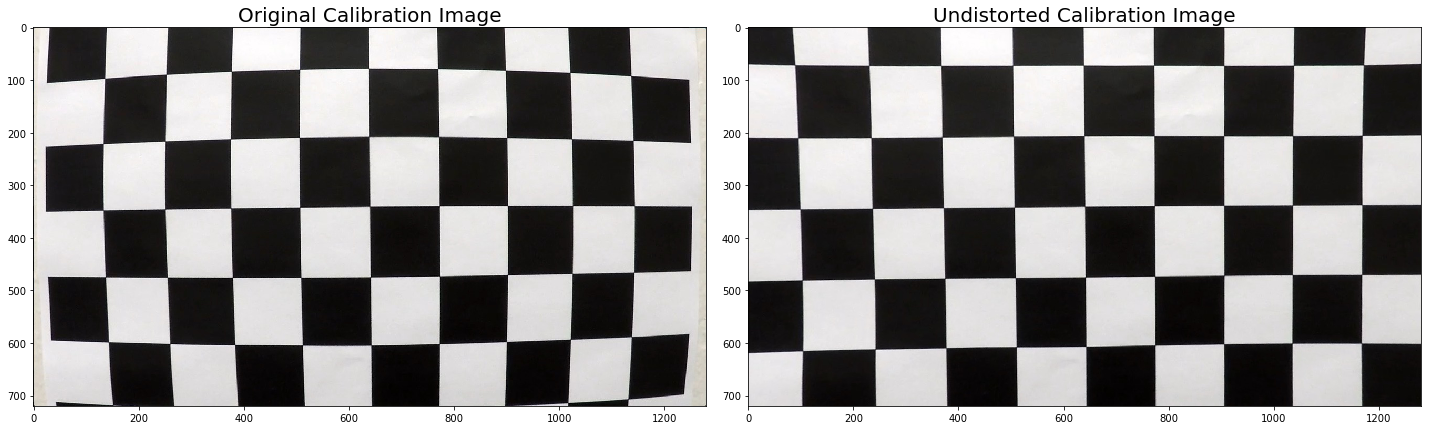

In [131]:
# Read in a test image
img = mpimg.imread('camera_cal/calibration1.jpg')
undistorted = camera.cal_undistort(img)

# Plot images (before/after)
plot_images_side_by_side(
    img, 'Original Calibration Image',
    undistorted, 'Undistorted Calibration Image'
)

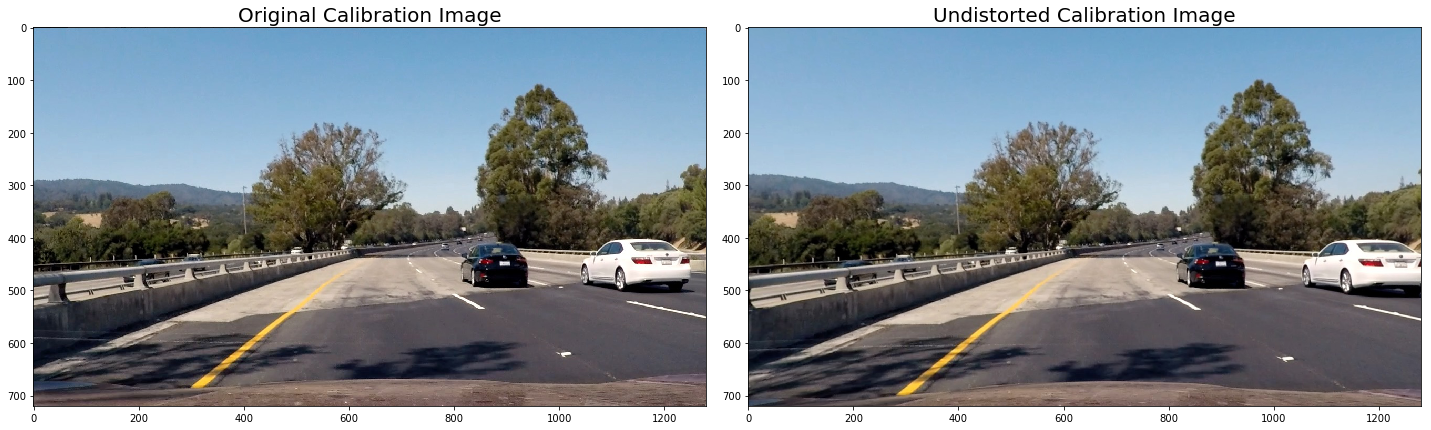

In [132]:
img = mpimg.imread('test_images/test4.jpg')
undistorted = camera.cal_undistort(img)

# Plot images (before/after)
plot_images_side_by_side(
    img, 'Original Calibration Image',
    undistorted, 'Undistorted Calibration Image'
)

## Color and Gradient Threshold

In [146]:
def abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(0, 255)):
    # Calculate directional gradient
    #gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    gray = img
    if orient == 'x':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    if orient == 'y':
        sobel = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobel = np.absolute(sobel)
    scaled_sobel = np.uint8(255*abs_sobel/np.max(abs_sobel))
    # Apply threshold
    binary_output = np.zeros_like(scaled_sobel)
    binary_output[(scaled_sobel >= thresh[0]) & (scaled_sobel <= thresh[1])] = 1
    return binary_output

def mag_thresh(img, sobel_kernel=3, mag_thresh=(0, 255)):
    # Calculate gradient magnitude
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    mag = np.sqrt(sobelx * sobelx + sobely * sobely)
    scaled_mag = np.uint8(255*mag/np.max(mag))
    # Apply threshold
    binary_output = np.zeros_like(scaled_mag)
    binary_output[(scaled_mag >= mag_thresh[0]) & (scaled_mag <= mag_thresh[1])] = 1
    return binary_output

def dir_threshold(img, sobel_kernel=3, thresh=(0, np.pi/2)):
    # Calculate gradient direction
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0, ksize=sobel_kernel)
    sobely = cv2.Sobel(gray, cv2.CV_64F, 0, 1, ksize=sobel_kernel)
    abs_sobelx = np.absolute(sobelx)
    abs_sobely = np.absolute(sobely)
    absgraddir = np.arctan2(abs_sobely, abs_sobelx)
    # Apply threshold
    binary_output = np.zeros_like(absgraddir)
    binary_output[(absgraddir >= thresh[0]) & (absgraddir <= thresh[1])] = 1
    return binary_output

In [137]:
def combine(img, ksize=15):
    # Choose a Sobel kernel size
    #ksize = 15 # Choose a larger odd number to smooth gradient measurements
    
    # Apply each of the thresholding functions
    gradx = abs_sobel_thresh(img, orient='x', sobel_kernel=ksize, thresh=(10, 160))  # (10, 100)
    grady = abs_sobel_thresh(img, orient='y', sobel_kernel=ksize, thresh=(10, 160))   # (10, 100)
    mag_binary = mag_thresh(img, sobel_kernel=ksize, mag_thresh=(30, 100))            # (30, 100)
    dir_binary = dir_threshold(img, sobel_kernel=ksize, thresh=(0.7, 1.3))           # (0.7, 1.3)
    
    # Combine the thresholding functions
    combined = np.zeros_like(dir_binary)
    combined[((gradx == 1) & (grady == 1)) | ((mag_binary == 1) & (dir_binary == 1))] = 1
    
    return combined

From Udacity Lesson #30:

In [138]:
def pipeline(img, s_thresh=(170, 255), sx_thresh=(20, 100)):
    img = np.copy(img)
    
    # Convert to HLS color space and separate the V channel
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    gray = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)
    
    # Sobel x
    sobelx = cv2.Sobel(gray, cv2.CV_64F, 1, 0) # Take the derivative in x
    abs_sobelx = np.absolute(sobelx) # Absolute x derivative to accentuate lines away from horizontal
    scaled_sobel = np.uint8(255*abs_sobelx/np.max(abs_sobelx))
    
    # Threshold x gradient
    sxbinary = np.zeros_like(scaled_sobel)
    sxbinary[(scaled_sobel >= sx_thresh[0]) & (scaled_sobel <= sx_thresh[1])] = 1
    
    # Threshold color channel
    s_binary = np.zeros_like(s_channel)
    s_binary[(s_channel >= s_thresh[0]) & (s_channel <= s_thresh[1])] = 1
    
    # Stack each channel
    # Note color_binary[:, :, 0] is all 0s, effectively an all black image. It might
    # be beneficial to replace this channel with something else.
    color_binary = np.dstack((np.zeros_like(sxbinary), sxbinary, s_binary)) * 255
    return color_binary

In [153]:
def pipeline(img):
    
    print(img.shape)
    
    hls = cv2.cvtColor(img, cv2.COLOR_RGB2HLS)
    h_channel = hls[:,:,0]
    l_channel = hls[:,:,1]
    s_channel = hls[:,:,2]
    img = s_channel
    
    print(img.shape)
    
    sobelX = abs_sobel_thresh(img, orient='x', sobel_kernel=3, thresh=(10, 160))
    sobelY = abs_sobel_thresh(img, orient='y', sobel_kernel=3, thresh=(10, 160))
    
    binary = np.zeros_like(sobelX) 
    binary[((sobelX == 1) & (sobelY == 1))] = 1
    return binary

## Perspective Transform

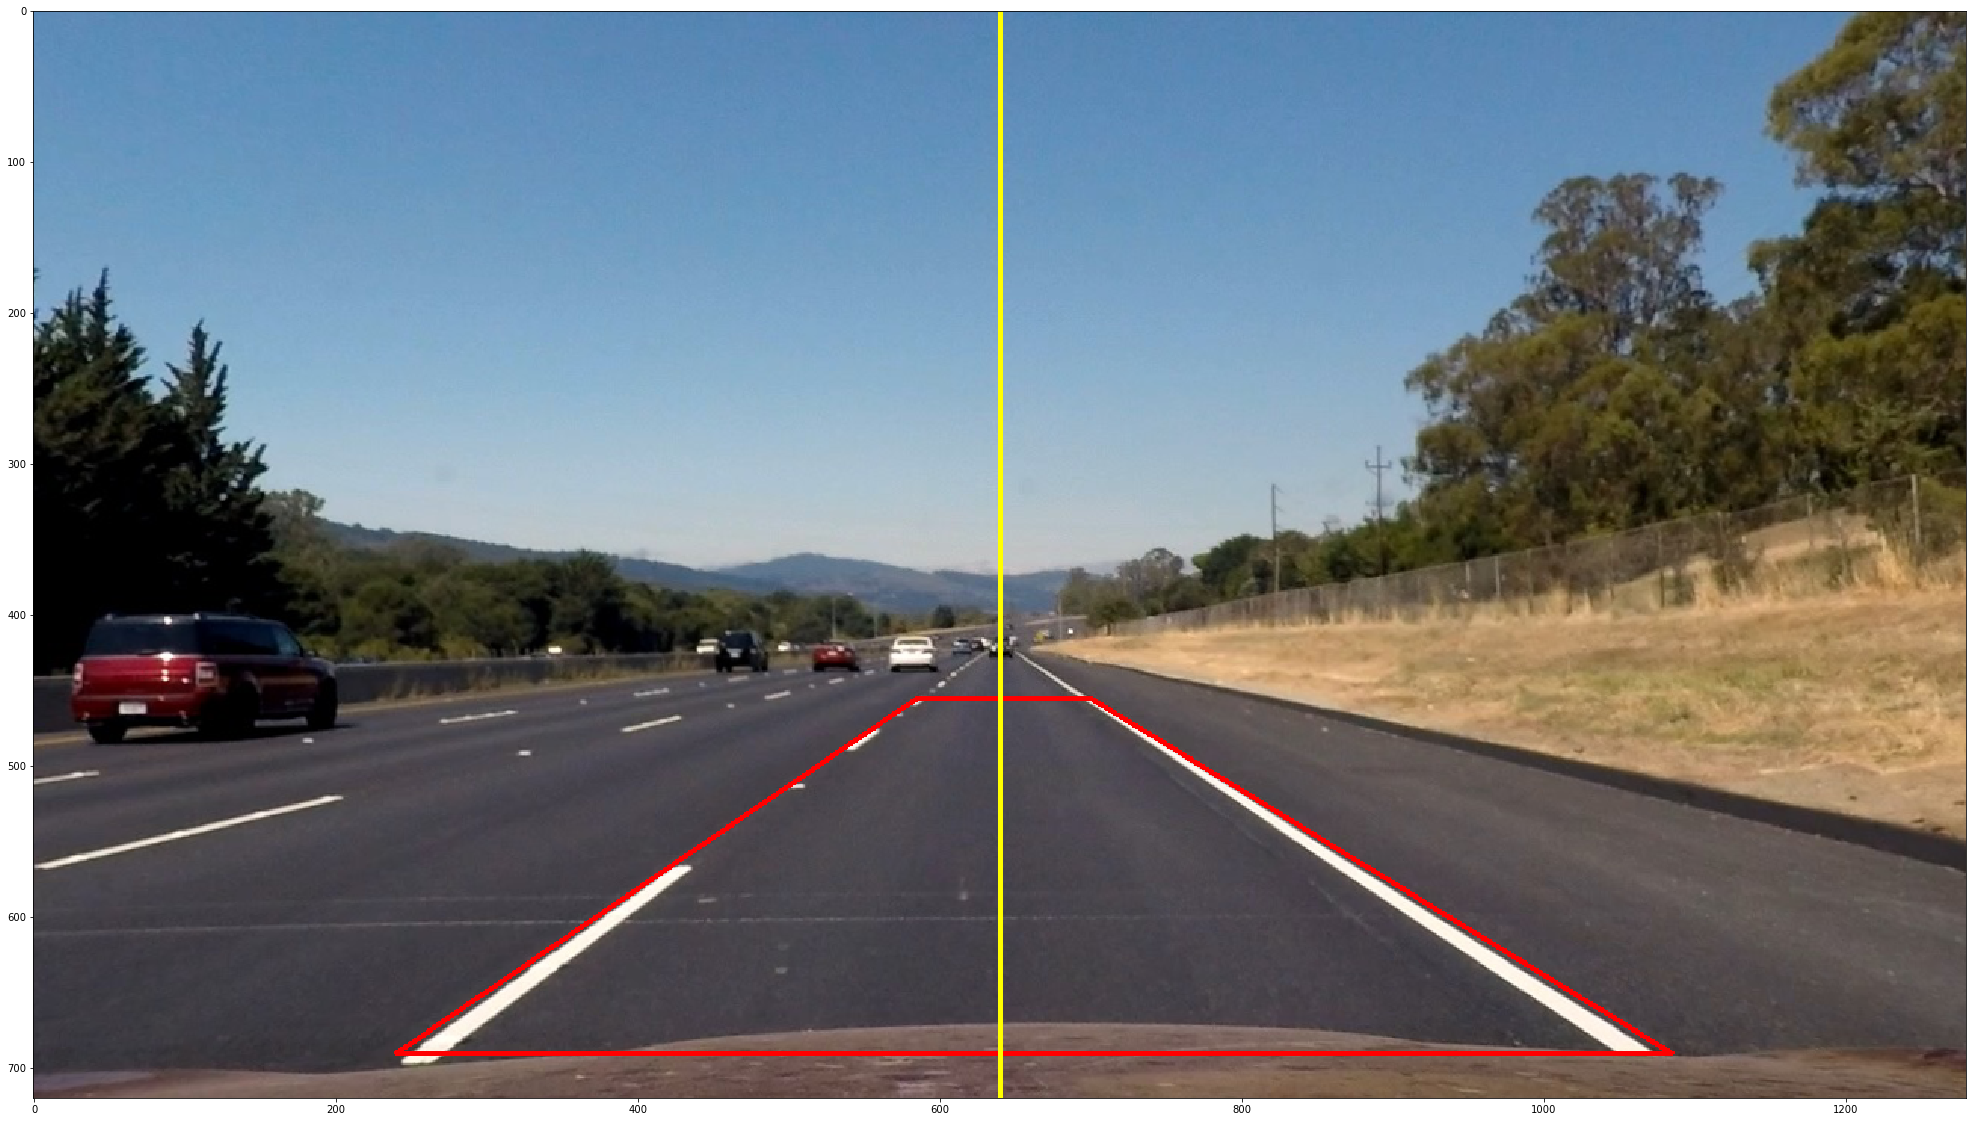

In [139]:
def perspective_transform(img):
    
    return img

# Load test images
#test_images = glob.glob('test_images/st*.jpg')

def load_images(filepath):
    images = list(map(lambda imageFileName: (imageFileName, cv2.imread(imageFileName)), glob.glob(filepath)))
    return images

test_images = load_images('./test_images/st*.jpg')

index = 0
original = cv2.cvtColor(test_images[index][1],cv2.COLOR_BGR2RGB)
undistorted = camera.cal_undistort(original)

img_size = undistorted.shape[1::-1]
copy = undistorted.copy()

bottomY = img_size[1] - 30
topY = 455

left1 = (240, bottomY)
left1_x, left1_y = left1
left2 = (585, topY)
left2_x, left2_y = left2

right1 = (700, topY)
right1_x, right1_y = right1
right2 = (1085, bottomY)
right2_x, right2_y = right2

# Plot 
color = [255, 0, 0]
w = 2
cv2.line(copy, left1, left2, color, w)
cv2.line(copy, left2, right1, color, w)
cv2.line(copy, right1, right2, color, w)
cv2.line(copy, right2, left1, color, w)
cv2.line(copy, (int(img_size[0]/2),0), (int(img_size[0]/2),img_size[1]), [255, 255, 0], w)
fig, ax = plt.subplots(figsize=(40, 20))
ax.imshow(copy)

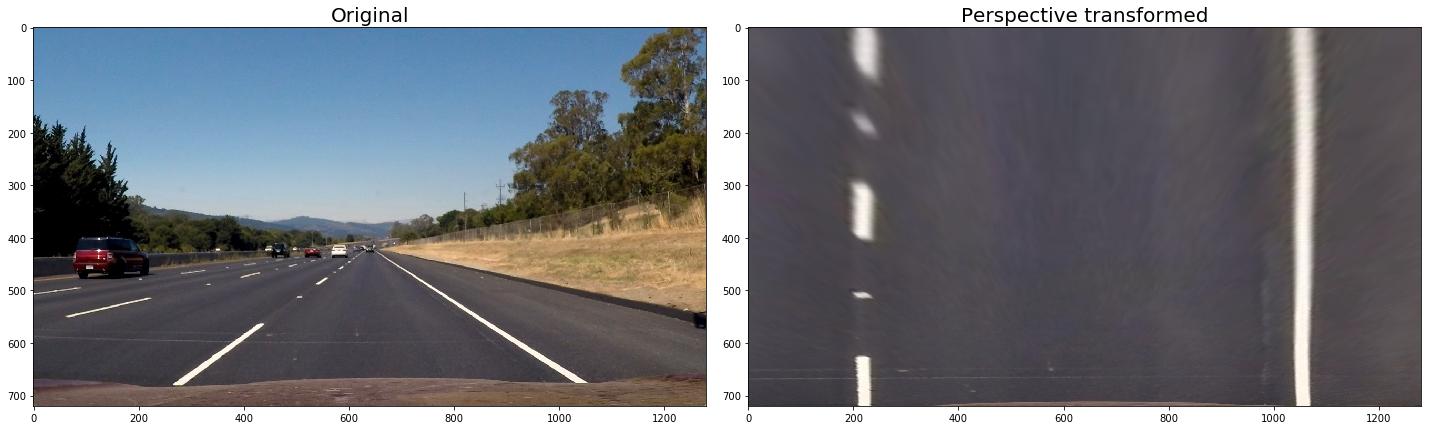

In [149]:
gray = cv2.cvtColor(undistorted, cv2.COLOR_BGR2GRAY)
src = np.float32([ 
    [left2_x, left2_y],
    [right1_x, right1_y],
    [right2_x, right2_y],
    [left1_x, left1_y]
])

# Using an offset on the left and right side allows the lanes to curve.
offset = 200
dst = np.float32([
    [offset, 0],
    [xSize-offset, 0],
    [xSize-offset, ySize], 
    [offset, ySize]
])

# Calculate M, the transform matrix
M = cv2.getPerspectiveTransform(src, dst)
Minv = cv2.getPerspectiveTransform(dst, src)

# Warp the image to a top-down-view
warped = cv2.warpPerspective(undistorted, M, (xSize, ySize))

# Plot images (before/after)
plot_images_side_by_side(
    original, 'Original',
    warped, 'Perspective transformed'
)

## Detect Lane Lines

(720, 1280, 3)
(720, 1280)


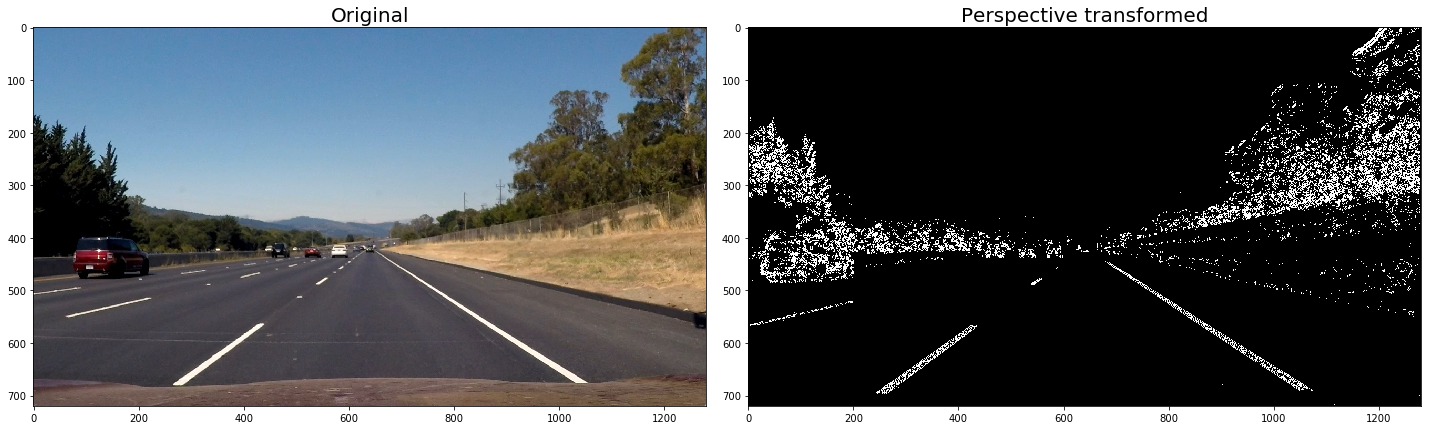

In [156]:

binary = pipeline(undistorted)

plot_images_side_by_side(
    original, 'Original',
    binary, 'Perspective transformed'
)

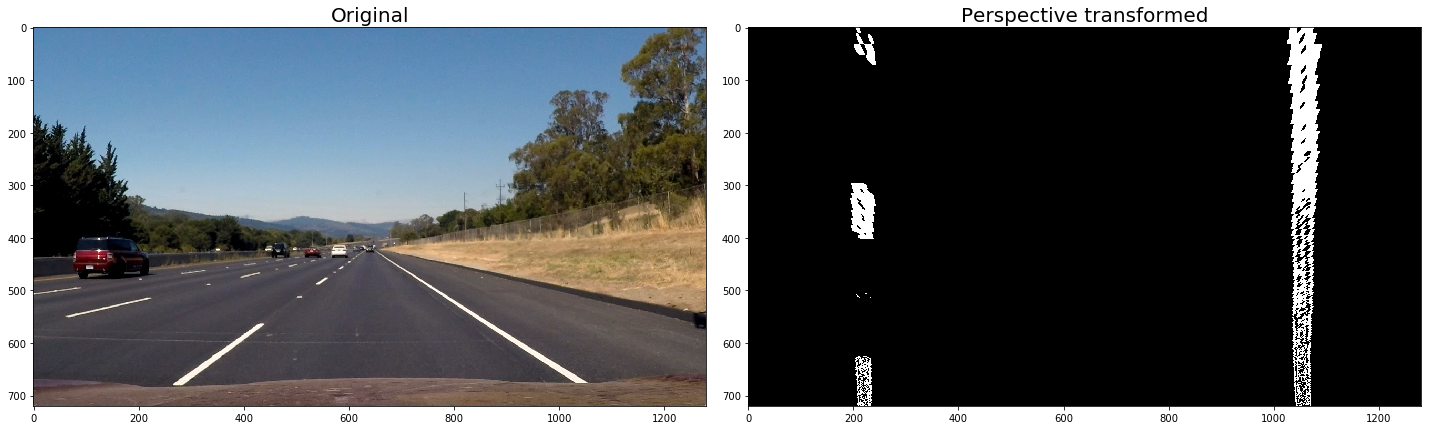

In [160]:

binary_warped = cv2.warpPerspective(binary, M, (xSize, ySize))

plot_images_side_by_side(
    original, 'Original',
    binary_warped, 'Perspective transformed'
)

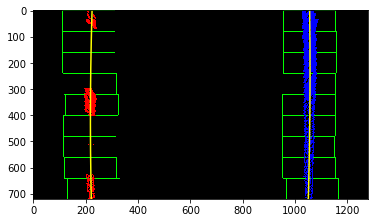

In [238]:
# Define conversions in x and y from pixels space to meters
ym_per_pix = 30/720 # meters per pixel in y dimension
xm_per_pix = 3.7/700 # meters per pixel in x dimension

def find_lane_lines(binary_warped, nwindows=9, margin=100, minpix=50):
    """
    Find the polynomial representation of the lane lines in the `binary_warped` using:
    - `nwindows` the number of sliding windows.
    - `margin` as the width of the windows +/- margin.
    - `minpix` as the minimum number of pixels found to recenter window.
    Returns [tbd]
    """
    # Take a histogram of the bottom half of the image
    histogram = np.sum(binary_warped[binary_warped.shape[0]//2:,:], axis=0)
    # Create an output image to draw on and  visualize the result
    out_img = np.dstack((binary_warped, binary_warped, binary_warped))*255
    # Find the peak of the left and right halves of the histogram
    # These will be the starting point for the left and right lines
    midpoint = np.int(histogram.shape[0]/2)
    leftx_base = np.argmax(histogram[:midpoint])
    rightx_base = np.argmax(histogram[midpoint:]) + midpoint
    
    # Set height of windows
    window_height = np.int(binary_warped.shape[0]/nwindows)
    # Identify the x and y positions of all nonzero pixels in the image
    nonzero = binary_warped.nonzero()
    nonzeroy = np.array(nonzero[0])
    nonzerox = np.array(nonzero[1])
    # Current positions to be updated for each window
    leftx_current = leftx_base
    rightx_current = rightx_base
    # Create empty lists to receive left and right lane pixel indices
    left_lane_inds = []
    right_lane_inds = []
    
    # Step through the windows one by one
    for window in range(nwindows):
        # Identify window boundaries in x and y (and right and left)
        win_y_low = binary_warped.shape[0] - (window+1)*window_height
        win_y_high = binary_warped.shape[0] - window*window_height
        win_xleft_low = leftx_current - margin
        win_xleft_high = leftx_current + margin
        win_xright_low = rightx_current - margin
        win_xright_high = rightx_current + margin
        # Draw the windows on the visualization image
        cv2.rectangle(out_img,(win_xleft_low,win_y_low),(win_xleft_high,win_y_high), (0,255,0), 2) 
        cv2.rectangle(out_img,(win_xright_low,win_y_low),(win_xright_high,win_y_high), (0,255,0), 2) 
        # Identify the nonzero pixels in x and y within the window
        good_left_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xleft_low) & (nonzerox < win_xleft_high)).nonzero()[0]
        good_right_inds = ((nonzeroy >= win_y_low) & (nonzeroy < win_y_high) & (nonzerox >= win_xright_low) & (nonzerox < win_xright_high)).nonzero()[0]
        # Append these indices to the lists
        left_lane_inds.append(good_left_inds)
        right_lane_inds.append(good_right_inds)
        # If you found > minpix pixels, recenter next window on their mean position
        if len(good_left_inds) > minpix:
            leftx_current = np.int(np.mean(nonzerox[good_left_inds]))
        if len(good_right_inds) > minpix:        
            rightx_current = np.int(np.mean(nonzerox[good_right_inds]))
    
    # Concatenate the arrays of indices
    left_lane_inds = np.concatenate(left_lane_inds)
    right_lane_inds = np.concatenate(right_lane_inds)
    
    # Extract left and right line pixel positions
    leftx = nonzerox[left_lane_inds]
    lefty = nonzeroy[left_lane_inds]
    rightx = nonzerox[right_lane_inds]
    righty = nonzeroy[right_lane_inds]
    
    # Fit a second order polynomial to each (in pixels)
    left_fit = np.polyfit(lefty, leftx, 2)
    right_fit = np.polyfit(righty, rightx, 2)
    
    # Fit a second order polynomial to each (in meters)
    left_fit_m = np.polyfit(lefty*ym_per_pix, leftx*xm_per_pix, 2)
    right_fit_m = np.polyfit(righty*ym_per_pix, rightx*xm_per_pix, 2)
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy)

def find_and_visualize_lane_lines(binary_warped, plt):
    """
    Visualize the windows and fitted lane lines for `binary_warped`.
    Returns (`left_fit` and `right_fit`)
    """
    left_fit, right_fit, left_fit_m, right_fit_m, left_lane_inds, right_lane_inds, out_img, nonzerox, nonzeroy = find_lane_lines(binary_warped)
    
    # Generate x and y values for plotting
    ploty = np.linspace(0, binary_warped.shape[0]-1, num=binary_warped.shape[0])
    left_fitx = left_fit[0]*ploty**2 + left_fit[1]*ploty + left_fit[2]
    right_fitx = right_fit[0]*ploty**2 + right_fit[1]*ploty + right_fit[2]
    
    out_img[nonzeroy[left_lane_inds], nonzerox[left_lane_inds]] = [255, 0, 0]
    out_img[nonzeroy[right_lane_inds], nonzerox[right_lane_inds]] = [0, 0, 255]
    plt.imshow(out_img)
    plt.plot(left_fitx, ploty, color='yellow')
    plt.plot(right_fitx, ploty, color='yellow')
    
    return (left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx)

left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx = find_and_visualize_lane_lines(binary_warped, plt)


## Determine the Lane Curvature

In [223]:

def calculate_lane_curvature(left_fit_cr, right_fit_cr):
    # Calculate the new radii of curvature
    y_eval = 719.0
    left_curverad = ((1 + (2*left_fit_cr[0]*y_eval*ym_per_pix + left_fit_cr[1])**2)**1.5) / np.absolute(2*left_fit_cr[0])
    right_curverad = ((1 + (2*right_fit_cr[0]*y_eval*ym_per_pix + right_fit_cr[1])**2)**1.5) / np.absolute(2*right_fit_cr[0])
    # Now the radius of curvature is in meters
    # Example values: 632.1 m    626.2 m
    return (left_curverad, right_curverad)

left_curverad, right_curverad = calculate_lane_curvature(left_fit_m, right_fit_m)
print(left_curverad, 'm', right_curverad, 'm')


4518.89641833 m 6060.69457528 m


## Draw the detected Lane Lines back onto the image

In [293]:


def draw_lane_lines_on_image(undist, warped, left_fitx, right_fitx):
    
    # Create an image to draw the lines on
    warp_zero = np.zeros_like(warped).astype(np.uint8)
    color_warp = np.dstack((warp_zero, warp_zero, warp_zero))
    
    # Recast the x and y points into usable format for cv2.fillPoly()
    pts_left = np.array([np.transpose(np.vstack([left_fitx, ploty]))])
    pts_right = np.array([np.flipud(np.transpose(np.vstack([right_fitx, ploty])))])
    pts = np.hstack((pts_left, pts_right))
    
    # Draw the lane onto the warped blank image
    cv2.fillPoly(color_warp, np.int_([pts]), (0, 255, 0))
    
    # Warp the blank back to original image space using inverse perspective matrix (Minv)
    newwarp = cv2.warpPerspective(color_warp, Minv, (undist.shape[1], undist.shape[0])) 
    # Combine the result with the original image
    result = cv2.addWeighted(undist, 1, newwarp, 0.3, 0)
    
    return result

result = draw_lane_lines_on_image(undistorted, warped, left_fitx, right_fitx)

plot_images_side_by_side(
    undistorted, 'Undistorted Image',
    result, 'Undistorted Image with Lane Lines'
)

## Now: for every image

(720, 1280, 3)
(720, 1280)


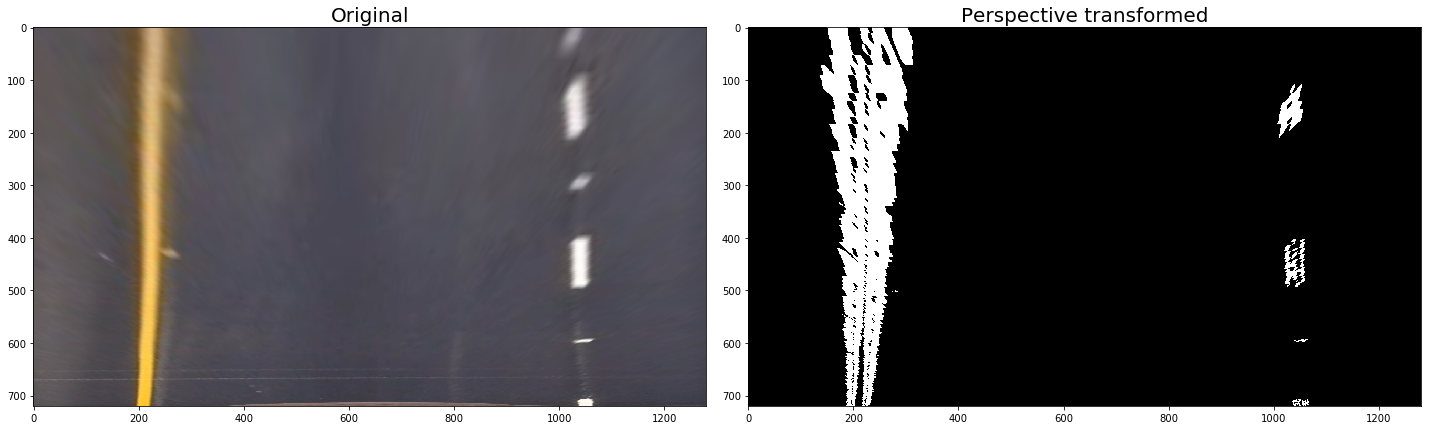

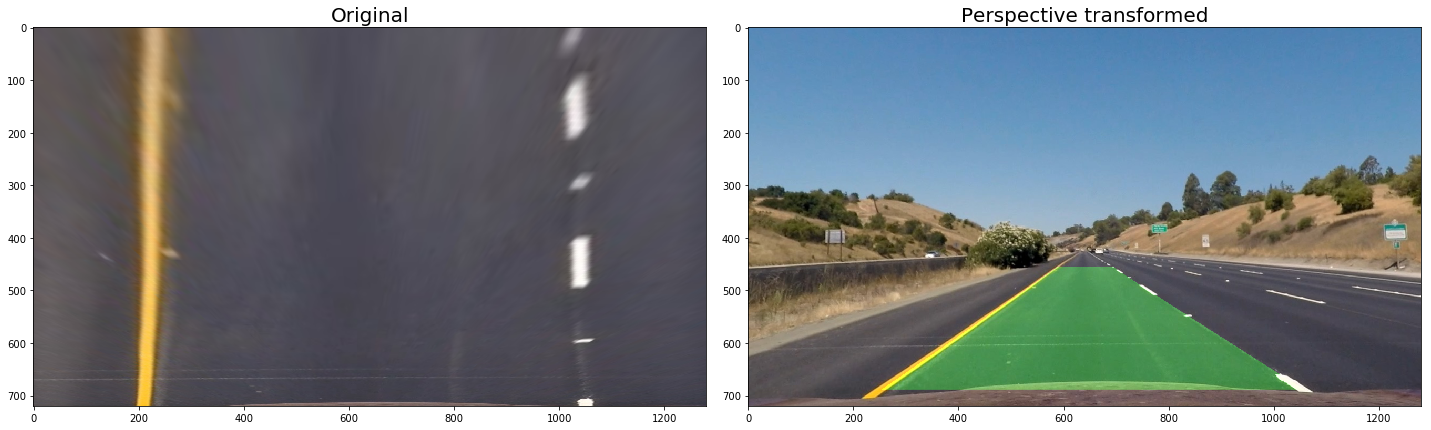

In [294]:
image_index = 1

orig = cv2.cvtColor(test_images[image_index][1], cv2.COLOR_BGR2RGB)

undi = camera.cal_undistort(orig)
warp = cv2.warpPerspective(undi, M, (xSize, ySize))

bina = pipeline(undi)
bina = cv2.warpPerspective(bina, M, (xSize, ySize))
left_fit, right_fit, left_fit_m, right_fit_m, left_fitx, right_fitx = find_and_visualize_lane_lines(bina, plt)
left_curverad, right_curverad = calculate_lane_curvature(left_fit_m, right_fit_m)
result = draw_lane_lines_on_image(undi, bina, left_fitx, right_fitx)

plot_images_side_by_side(
    orig, 'Original Image',
    undi, 'Undistorted Image'
)

plot_images_side_by_side(
    warp, 'Warped Image (undist)',
    bina, 'Perspective transformed'
)

plot_images_side_by_side(
    warp, 'Original',
    result, 'Undistorted Image with Lane Lines'
)
